##✍ В этом модуле вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем тесты для отбра признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
TARGET_NAME = 'reviewer_score'

In [3]:
!pip freeze > requirements.txt

### 1. Подгрузим наши данные из соревнования и объеденим их

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'C:/Users/d3en/OneDrive/Рабочий стол/dataScience/IDE/PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle/data_3/kaggle'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review— отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Тренировочный датасет состоит из 386803 строк и 17 столбцов, в двух столбцах имеются пропущенные значения: lat — географическая широта отеля и lng — географическая долгота отеля. девять столбцов представлены в виже числовых данных в форматах float64(4 столбца), int64(5 столбцов), остальные 8 столбцов в формате object. Тестовый датасет состоит 128935 из строк и 16 столбцов(без целевого).

## 2. Создание столбцов и обработка признаков

* Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм RandomForestRegressor. Он реализован в библиотеке sklearn.

* Для корректной работы все данные в датафрейме, который мы будем использовать при обучении модели, должны быть в числовых форматах int или float.

* Есть ещё одно ограничение: в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения нам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

* Таким образом, чтобы код, отвечающий за обучение модели, заработал, мы должны использовать в нём датафрейм, содержащий только количественные признаки и не содержащий пропущенных значений.

In [7]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### 2.1 Cоздадим новые признаки: странa, город и почтовый индекс

In [9]:
# Выделяем страну, город и почтовый индекс из адреса отеля
data['city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
data['country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
data['index'] = data['hotel_address'].apply(lambda x: x.split()[-4]+' '+x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])



#### 2.2 Заполним пропуски в координатах ('lat', 'lng').

In [10]:
# Посчитаем среднюю географическую координату для заполнения пропусков
geography = data.groupby(['city', 'index']).agg({'lat' : 'mean', 'lng' : 'mean'})

# добавим два новых поля со средним значением 
data = data.merge(geography, on=['city', 'index'], suffixes=('', '_mean')) 



In [11]:
display(data.info())
# выводим строки с пропусками
data[data.lat.isna()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,lat,lng,sample,reviewer_score,city,country,index,lat_mean,lng_mean
70483,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,10/13/2016,7.8,Hotel Atlanta,Australia,The reception staff are somewhat dour and cou...,21,2724,The hotel is pretty from the outside and quai...,...,294 day,NaN,NaN,0,0.0,Vienna,Austria,1090,48.219856,16.358965
70484,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,8/20/2015,7.8,Hotel Atlanta,Sweden,It is an old hotel with old furniture The roo...,26,2724,The price and the service,...,714 day,NaN,NaN,0,0.0,Vienna,Austria,1090,48.219856,16.358965
70485,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,44,5/1/2017,8.0,City Hotel Deutschmeister,Taiwan,WIFI is low speed,5,675,Good room good breakfast and good service,...,94 days,NaN,NaN,0,0.0,Vienna,Austria,1090,48.219856,16.358965
70486,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,3/28/2016,7.8,Hotel Atlanta,Czech Republic,No Negative,0,2724,Close to the city center good breakfast,...,493 day,NaN,NaN,0,0.0,Vienna,Austria,1090,48.219856,16.358965
70490,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,6/17/2017,7.8,Hotel Atlanta,United Kingdom,The male receptionist send us on a wild goose...,26,2724,My room was very hot but vey quiet One of the...,...,47 days,NaN,NaN,0,0.0,Vienna,Austria,1090,48.219856,16.358965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506092,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,7/8/2016,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United Kingdom,No Negative,0,1558,Lovely building with great views across Vienn...,...,391 day,NaN,NaN,1,10.0,Vienna,Austria,1160,48.214507,16.284504
506093,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,8/26/2015,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,Lebanon,Breakfast area had sticky floor for two days ...,19,1558,No Positive,...,708 day,NaN,NaN,1,5.0,Vienna,Austria,1160,48.214507,16.284504
506094,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,9/29/2015,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United Arab Emirates,The beds don t look like hotel beds and feels...,66,1558,The architecture is beautiful Surrounding sce...,...,674 day,NaN,NaN,1,6.7,Vienna,Austria,1160,48.214507,16.284504
506095,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,1/8/2017,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,Russia,No Negative,0,1558,Great beautiful place Cozy rooms with everyth...,...,207 day,NaN,NaN,1,9.6,Vienna,Austria,1160,48.214507,16.284504


In [12]:
# проверяем пропуски
data['lat'].isna().sum()

3268

In [13]:
# заменим пропуски в географических данных, средними значениями непустых ячеек, исходя из индексов
data['lat'] = np.where(data.lat.isna(), data.lat_mean, data.lat)
data['lng'] = np.where(data.lng.isna(), data.lng_mean, data.lng)



# удаляем вспомогательные столбцы со средним значением географических данных
data = data.drop(['lat_mean', 'lng_mean'], axis=1)

In [14]:
# кодируем город и индекс с помощью  метода LabelEncode, страну не кодируем, так как количество городов совпвадает с количеством стран

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
data['city'] = LabelEncoder().fit_transform(data['city'])
data['index'] = LabelEncoder().fit_transform(data['index'])

data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city,country,index
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,3,Italy,187
1,Via Senigallia 6 20161 Milan Italy,904,6/4/2017,8.1,Hotel Da Vinci,Bulgaria,Good be in a better maintenance,8,16670,Great breakfast and very kind personnel Spacy...,...,6,"[' Leisure trip ', ' Couple ', ' Double Room '...",60 days,45.533137,9.171102,0,0.0,3,Italy,187
2,Via Senigallia 6 20161 Milan Italy,904,1/6/2017,8.1,Hotel Da Vinci,Germany,When we were watching tv and communicating wi...,38,16670,No Positive,...,2,"[' Leisure trip ', ' Couple ', ' Double Room '...",209 day,45.533137,9.171102,0,0.0,3,Italy,187
3,Via Senigallia 6 20161 Milan Italy,904,10/22/2016,8.1,Hotel Da Vinci,Ireland,We had carvery dinner on our first night grea...,18,16670,We needed more pillows they came very quick G...,...,4,"[' Leisure trip ', ' Couple ', ' Double Room '...",285 day,45.533137,9.171102,0,0.0,3,Italy,187
4,Via Senigallia 6 20161 Milan Italy,904,12/12/2015,8.1,Hotel Da Vinci,Austria,Die Adresse ist wrong very difficult to acces...,11,16670,Room decor Fr hst ck,...,2,"[' Leisure trip ', ' Family with older childre...",600 day,45.533137,9.171102,0,0.0,3,Italy,187


#### 2.3 Выделим из 'reviewer_nationality' 10 чаще встрчающихся, а остальные закодируем как 'Other', затем закодируем признак с помощью  LabelEncoder

In [15]:
#Оставим только 10 наиболее активных национальностей
popul_nationalities= data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x:x if x in popul_nationalities else 'Other')

In [16]:
# закодирeм признак reviewer_nationality с помощью LabelEncoder
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,city,country,index
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,3,Italy,187
1,Via Senigallia 6 20161 Milan Italy,904,6/4/2017,8.1,Hotel Da Vinci,10,Good be in a better maintenance,8,16670,Great breakfast and very kind personnel Spacy...,...,6,"[' Leisure trip ', ' Couple ', ' Double Room '...",60 days,45.533137,9.171102,0,0.0,3,Italy,187
2,Via Senigallia 6 20161 Milan Italy,904,1/6/2017,8.1,Hotel Da Vinci,2,When we were watching tv and communicating wi...,38,16670,No Positive,...,2,"[' Leisure trip ', ' Couple ', ' Double Room '...",209 day,45.533137,9.171102,0,0.0,3,Italy,187


#### 2.4 Работа с датами отзывов

In [17]:
# переводим нужную нам информацию в формат datatime
data['review_date'] = pd.to_datetime(data['review_date'])

# Разделяем один признак 'review_date' на несколько:'season','month','year','day','day_of_week'
data['season'] = data['review_date'].dt.quarter.astype(int)
data['month'] = data['review_date'].dt.month.astype(int)
data['year'] = data['review_date'].dt.year.astype(int)
data['day'] = data['review_date'].dt.day.astype(int)

data['day_of_week'] = data['review_date'].dt.dayofweek.astype(int)
# Добавим новый признак выходной:'is_weekend'
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x>4 else 0)
# Добавим новые признаки разбитые на времена года
data['is_spring'] = data['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
data['is_summer'] = data['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
data['is_autumn'] = data['month'].apply(lambda x: 1 if x in [9,10,11] else 0)
data['is_winter'] = data['month'].apply(lambda x: 1 if x in [12,1,2] else 0)

# удаляем поле 'review_date'
data.drop(['review_date'], inplace=True, axis=1)

#### 2.5 Работа с отзывами
##### Используя библиотеку для обработки текстовой речи, мы попытаемся извлечь из отзывов дополнительные значимые признаки.

In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

analyz = SentimentIntensityAnalyzer()

# проводим анализ текста с помощью SentimentIntensityAnalyzer()
data['review_neg'] = data['negative_review'].apply(lambda x: analyz.polarity_scores(x))
data['review_pos'] = data['positive_review'].apply(lambda x: analyz.polarity_scores(x))

# результаты помещаем в data
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['review_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['review_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

data.head(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\d3en\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,review_neg,review_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,10,Good be in a better maintenance,8,16670,Great breakfast and very kind personnel Spacy...,10,...,"{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'comp...","{'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'comp...",0.000,0.341,0.659,0.7003,0.000,0.435,0.565,0.8313
2,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,2,When we were watching tv and communicating wi...,38,16670,No Positive,0,...,"{'neg': 0.068, 'neu': 0.861, 'pos': 0.071, 'co...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.068,0.861,0.071,0.0258,0.379,0.000,0.621,0.3400
3,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,3,We had carvery dinner on our first night grea...,18,16670,We needed more pillows they came very quick G...,27,...,"{'neg': 0.0, 'neu': 0.855, 'pos': 0.145, 'comp...","{'neg': 0.0, 'neu': 0.786, 'pos': 0.214, 'comp...",0.000,0.855,0.145,0.3716,0.000,0.786,0.214,0.7408
4,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,10,Die Adresse ist wrong very difficult to acces...,11,16670,Room decor Fr hst ck,6,...,"{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.583,0.417,0.000,-0.8687,0.000,1.000,0.000,0.0000


In [19]:
# отбор нечисловых колонок

df_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['hotel_address' 'hotel_name' 'negative_review' 'positive_review' 'tags'
 'days_since_review' 'country' 'review_neg' 'review_pos']


In [20]:
# убираем признаки которые еще не успели обработать,
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

<AxesSubplot:>

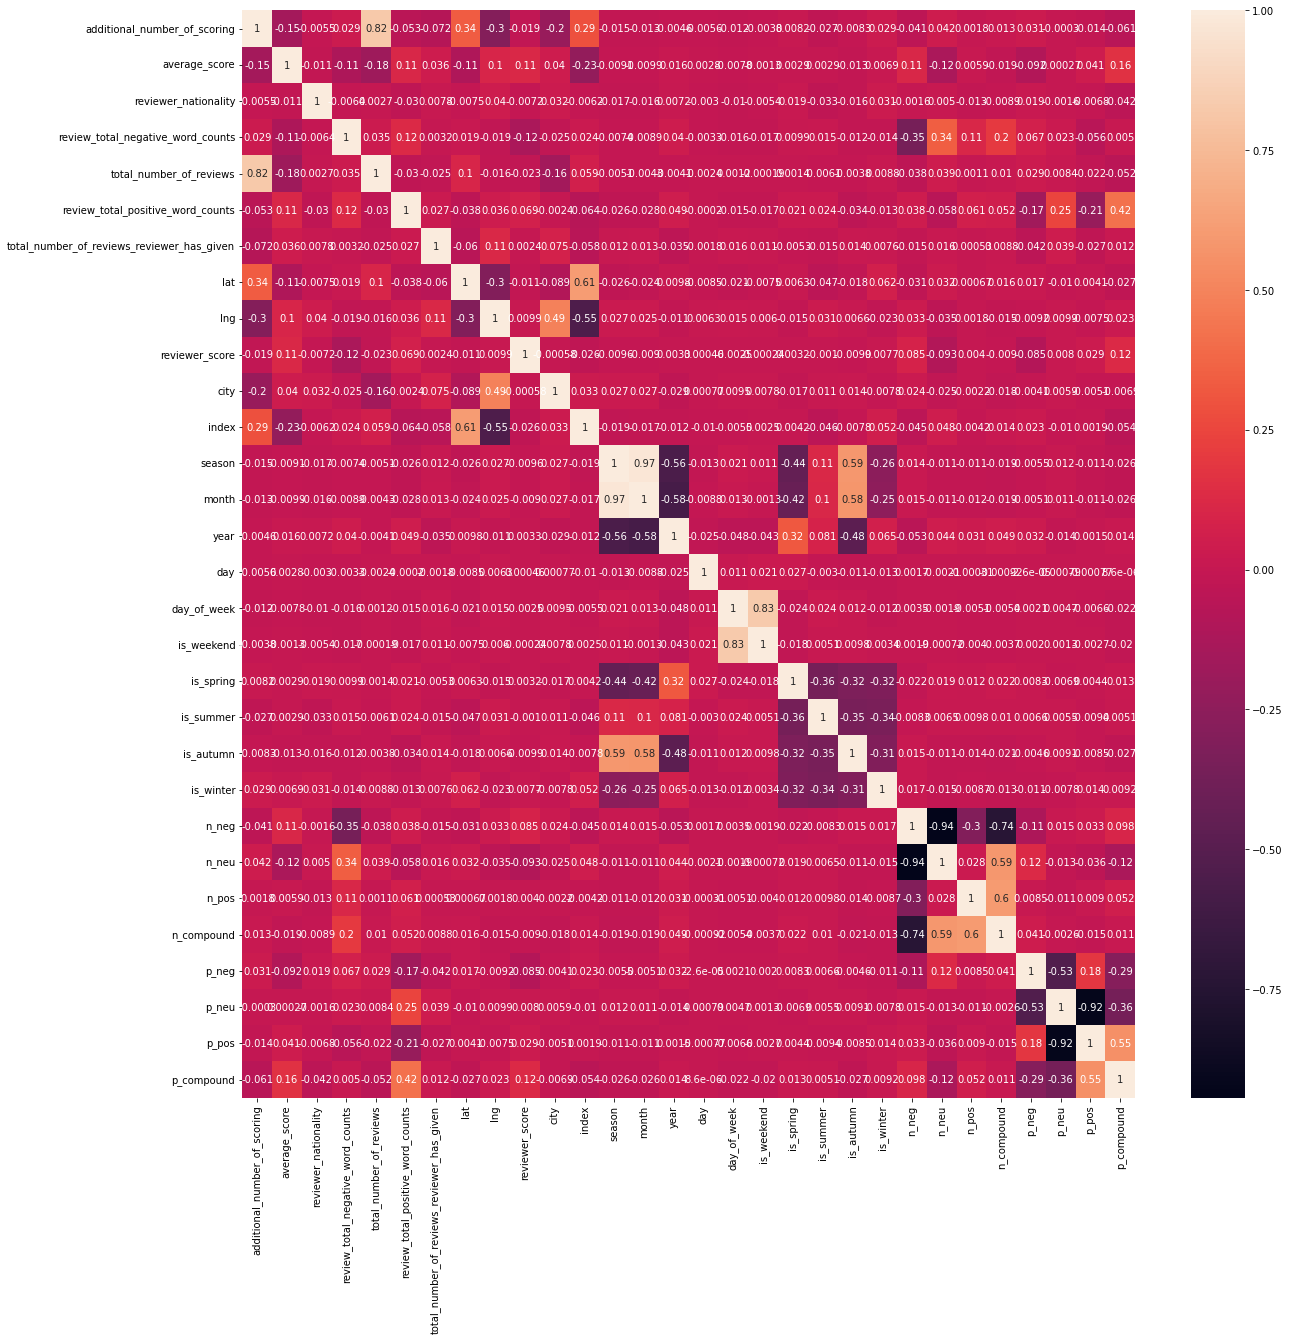

In [22]:
# строим матрицу корреляции
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [23]:
#### Очистим датасет от сильно коррелирующих признаков, на основании информации из матрицы корреляций.
data.drop([ 'month', 'additional_number_of_scoring','is_weekend'], axis = 1, inplace=True) 

<AxesSubplot:>

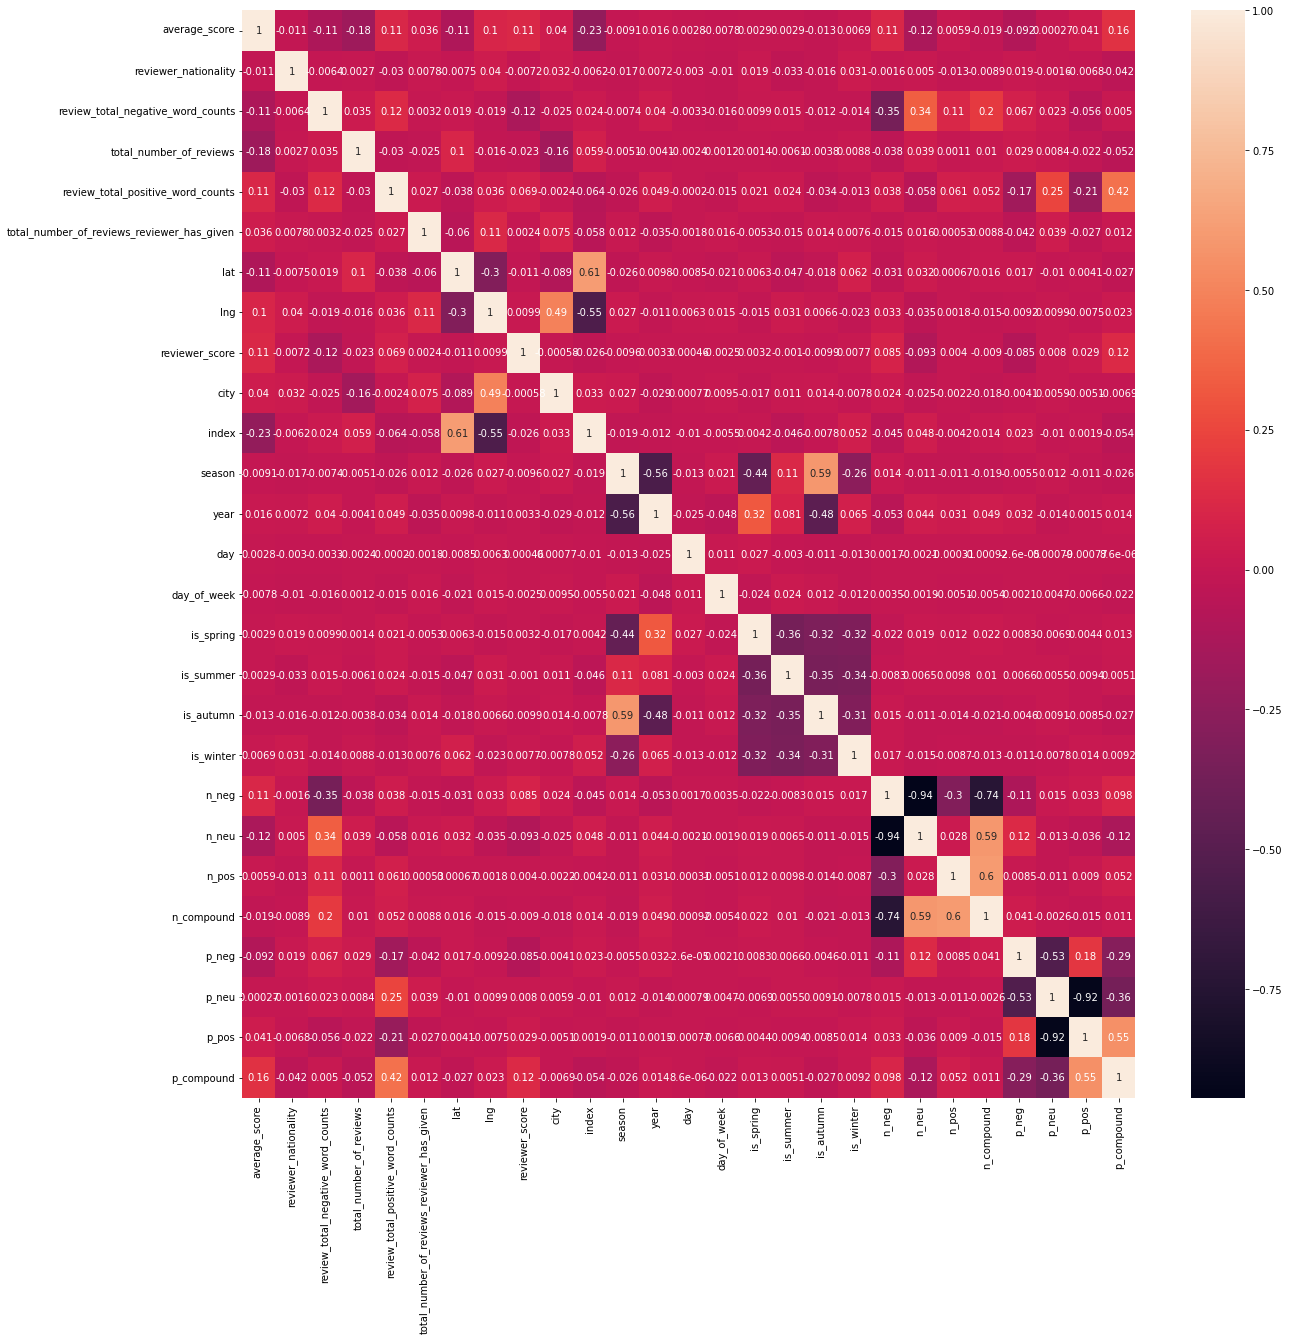

In [24]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   reviewer_nationality                        515738 non-null  int32  
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [26]:
# непрерывные признаки
num_cols = [
     'average_score', 'review_total_negative_word_counts',
     'total_number_of_reviews', 
     'review_total_positive_word_counts', 
     'total_number_of_reviews_reviewer_has_given',
      'lng','n_neg','n_neu',
     'n_pos','n_compound', 'p_neg','p_neu', 'p_pos', 'p_compound'
    
     ]

# категориальные признаки
cat_cols = ['reviewer_nationality',
     'city',
     'season',
     'year', 'day',
     'day_of_week','is_spring', 
     'is_summer', 'is_autumn','is_winter', 
          ]

In [32]:
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<AxesSubplot:>

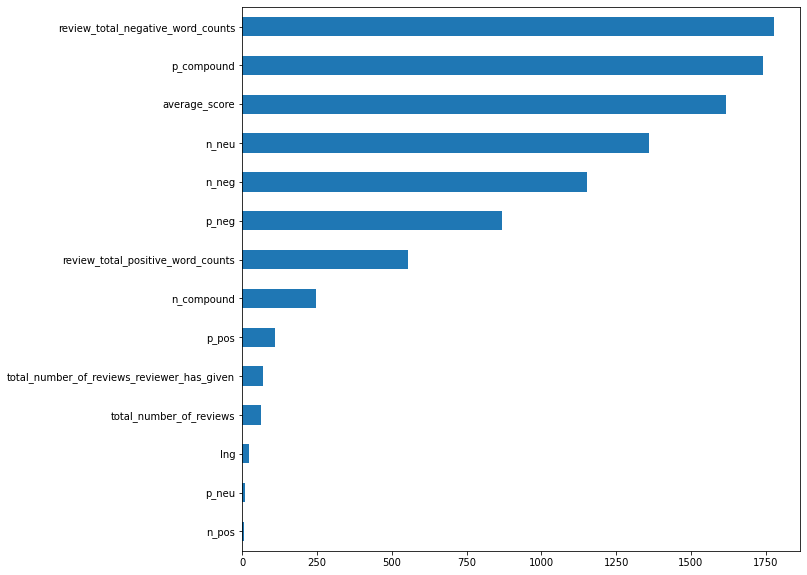

In [33]:
from sklearn.feature_selection import f_classif # anova

plt.rcParams['figure.figsize'] = (10,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

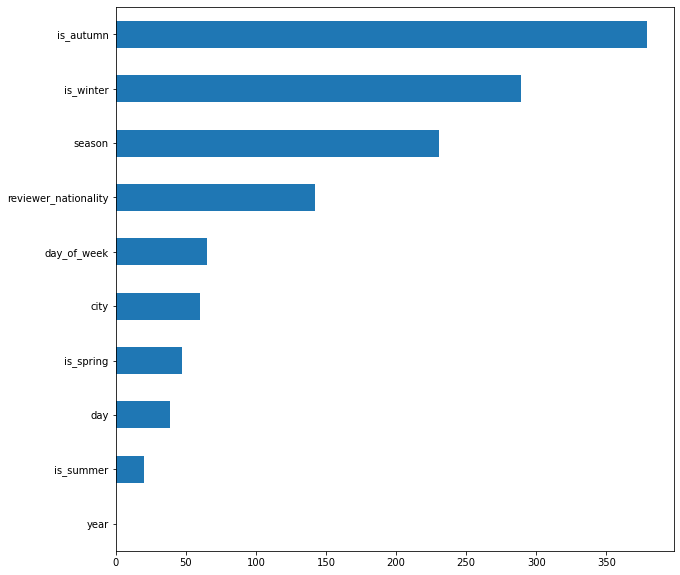

In [34]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### 3. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм RandomForestRegressor. Он реализован в библиотеке sklearn.

In [35]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

In [36]:
# разделяем тренинговый датасет: 75% на обучение, 25% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
# проверяем размерности получившихся датасетов
train_data.shape, test_data.shape, X.shape, X_train.shape, X_test.shape

((386803, 27), (128935, 27), (386803, 26), (290102, 26), (96701, 26))

In [38]:
# создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s


MAPE: 0.126147665683826


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


###4. ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [39]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [40]:
predict_submission = regr.predict(test_data)
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished


array([8.663, 8.768, 6.4  , ..., 9.667, 9.755, 9.526])

In [41]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('final_submission_2.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.663,488440
1,8.768,274649
2,6.400,374688
3,8.282,404352
4,5.210,451596
5,6.413,302161
6,8.294,317079
7,9.072,13963
8,8.650,159785
9,7.064,195089
